Step 1: Imports

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


Step 2: Prepare Data Transforms

In [2]:
train_transforms = transforms.Compose([transforms.RandomRotation((-6.0, 6.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])

Step 3: Creating datasets

In [3]:
train = datasets.MNIST('./data', train = True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 66437904.58it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 95987079.10it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21061469.02it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16799408.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Step 4: Creating data loaders

In [4]:
SEED = 1

cuda = torch.cuda.is_available()
print("Is cuda available? ", cuda)

#set the seed of the random number generator to a fixed value
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle = True, batch_size = 128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


Is cuda available?  True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Step 5: Data Stats

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


TypeError: ignored

NameError: ignored

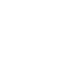

In [6]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Step 6: Model

In [7]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 12, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8, RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF = 18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 4, RF = 22
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 2, RF = 26
        # OUTPUT BLOCK
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 2, RF = 26

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1))
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

Step 7: Model Parameters

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             120
           Conv2d-11           [-1, 12, 10, 10]           1,080
      BatchNorm2d-12           [-1, 12, 10, 10]              24

Step 8: Training and Testing

In [9]:
from tqdm import tqdm

train_acc = []
test_acc = []
train_losses = []
test_losses = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim = 1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


Step 9: Train and Test calls

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 16
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print(f"current learing rate is {optimizer.param_groups[0]['lr']}")
    test(model, device, test_loader)

EPOCH: 0


Loss=0.14035582542419434 Batch_id=468 Accuracy=88.49: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s]

current learing rate is 0.01



Test set: Average loss: 0.0741, Accuracy: 9806/10000 (98.06%)

EPOCH: 1


Loss=0.0633956715464592 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s]

current learing rate is 0.01



Test set: Average loss: 0.0440, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.13735328614711761 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:23<00:00, 20.11it/s]


current learing rate is 0.01

Test set: Average loss: 0.0531, Accuracy: 9839/10000 (98.39%)

EPOCH: 3


Loss=0.021535390987992287 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]

current learing rate is 0.01



Test set: Average loss: 0.0351, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.07335840165615082 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]

current learing rate is 0.01



Test set: Average loss: 0.0302, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.014956672675907612 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]

current learing rate is 0.01



Test set: Average loss: 0.0278, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.11269208043813705 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]

current learing rate is 0.01



Test set: Average loss: 0.0299, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


Loss=0.07216066122055054 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:23<00:00, 19.63it/s]

current learing rate is 0.001



Test set: Average loss: 0.0255, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.01073075458407402 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:21<00:00, 21.32it/s]

current learing rate is 0.001



Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.05157756805419922 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]

current learing rate is 0.001



Test set: Average loss: 0.0204, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


Loss=0.12781094014644623 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]

current learing rate is 0.001



Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.047352030873298645 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]

current learing rate is 0.001



Test set: Average loss: 0.0192, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


Loss=0.003946790937334299 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]

current learing rate is 0.001



Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.01231215987354517 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:23<00:00, 20.13it/s]

current learing rate is 0.001



Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.007360872346907854 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:23<00:00, 20.13it/s]


current learing rate is 0.001

Test set: Average loss: 0.0188, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.009504600428044796 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]

current learing rate is 0.0001



Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

